In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
import gc
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data import Dataset

from PIL import Image
import os
from IPython.display import display
from torchvision.transforms import ToPILImage
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import copy
import sys
import os
from torch.utils.data import Dataset
import pickle
from PIL import Image, ImageOps
import random
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle


In [ ]:
#### Some helper classes ####


class Slice:

        
    def __init__(self, base_folder_path, file_name):
    # Construct the full paths for the image and label
        image_path = os.path.join(base_folder_path, 'images', file_name)
        label_path = os.path.join(base_folder_path, 'labels', file_name)

        # Load and immediately close the image file
        with Image.open(image_path) as img:
            self.image = img.copy()

        # Load and immediately close the label file
        with Image.open(label_path) as lbl:
            self.label = lbl.copy()

        self.depth = int(os.path.splitext(file_name)[0])
        self.width, self.height = self.image.size


    def display_slice(self):
        # This method can display the image and the label side by side
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(self.image, cmap='gray')
        plt.title(f'Image - Depth: {self.depth} - {self.width}x{self.height}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(self.label, cmap='gray')
        plt.title(f'Label - Depth: {self.depth} - Area: {self.mask_area}')
        plt.axis('off')
        plt.show()

    def __repr__(self):
        return f'Slice(Depth: {self.depth}, Width: {self.width}, Height: {self.height}, Mask Area: {self.mask_area}, Mask Ratio: {self.mask_ratio:.2f})'


# Usage example
#base_folder_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/'
#file_name = '1259.tif'  # For example
#slice = Slice(base_folder_path, file_name)

    

In [10]:

class SliceStacker:
    def __init__(self, slices, channel_count=5):
        self.slices = slices
        self.channel_count = channel_count

    def get_stacked_images_and_labels(self, target_index):
        half_window = self.channel_count // 2
        stacked_images = []
        stacked_labels = []

        for i in range(target_index - half_window, target_index + half_window + 1):
            # Adjust index for edge cases
            adjusted_index = min(max(i, 0), len(self.slices) - 1)

            stacked_images.append(self.slices[adjusted_index].image)
            stacked_labels.append(self.slices[adjusted_index].label)

        return stacked_images, stacked_labels
    
    def create_non_overlapping_stacks(self):
        stacks = []
        for start_idx in range(0, len(self.slices), self.channel_count):
            stacked_images, stacked_labels = self.get_stacked_images_and_labels(start_idx)
            stacks.append((stacked_images, stacked_labels))
        return stacks


# Usage example:
# slice_stacker = SliceStacker(sorted_slices)  # sorted_slices is your sorted list of Slice objects
# tensor_volume = slice_stacker.get_stacked_tensor(3)  # For the 4th slice (index 3)
# slice_stacker = SliceStacker(sorted_slices) 
# save_path = f'{folder_index}_{middle_slice_index:04d}_{stack_size}.pt'
# slice_stacker.save_stacked_tensor(3, save_path)


In [11]:
class SliceCollection:
    def __init__(self, base_folder_path):
        self.base_folder_path = base_folder_path
        self.slices = self._load_slices()

    def _load_slices(self):
        image_files = os.listdir(os.path.join(self.base_folder_path, 'images'))
        # Filter out non-TIFF files and sort by depth
        image_files = sorted([f for f in image_files if f.lower().endswith('.tif')], key=lambda x: int(os.path.splitext(x)[0]))

        # Create Slice objects
        slices = [Slice(self.base_folder_path, file_name) for file_name in image_files]
        return slices

    @property
    def collection_length(self):
        return len(self.slices)

    def get_slices_from_depth(self, start_depth, count):
        # Find the index of the slice with the specified start_depth
        start_index = next((index for index, s in enumerate(self.slices) if s.depth == start_depth), None)
        
        # If start_depth is not found or count is invalid, return an empty list
        if start_index is None or count <= 0:
            return []

        # Return the specified number of slices starting from start_depth
        return self.slices[start_index:start_index + count]

    def display_slices(self, num_slices=10):
        # Display the first 'num_slices' slices
        for slice_obj in self.slices[:num_slices]:
            slice_obj.display_slice()

# Usage example
#base_folder_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/'
#slice_collection = SliceCollection(base_folder_path)
# print(slice_collection.collection_length)  # Print the total number of slices in the collection
# selected_slices = slice_collection.get_slices_from_depth(3, 5)  # Get 5 slices starting from depth 3



In [12]:
# Assuming SliceCollection and SliceStacker are defined as in your initial code

# Step 1: Create a SliceCollection object
#base_folder_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/'
#base_folder_path = 'blood-vessel-segmentation/train/kidney_1_dense/'
# Create a SliceCollection and SliceStacker
#slice_collection = SliceCollection(base_folder_path)
#slice_stacker = SliceStacker(slice_collection.slices)

In [10]:
# Get a stack of images and labels around a specific index
target_index = 693  # Example index
image_stack, label_stack = slice_stacker.get_stacked_images_and_labels(target_index)
# Display the middle image and label from the stack
middle_image = image_stack[len(image_stack) // 2]
middle_label = label_stack[len(label_stack) // 2]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(middle_image, cmap='gray')
plt.title(f'Image at Index {target_index}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(middle_label, cmap='gray')
plt.title(f'Label at Index {target_index}')
plt.axis('off')

plt.show()

In [13]:
class Chunk:
    def __init__(self, image_chunks, label_chunks, target_label):
        self.image_chunks = image_chunks
        self.label_chunks = label_chunks
        self.target_label = target_label
        
    def to_tensor(self):
        # Convert to tensor without normalization
        to_tensor_transform = transforms.ToTensor()
        self.tensor_images = torch.stack([to_tensor_transform(img) for img in self.image_chunks])
        self.tensor_labels = torch.stack([to_tensor_transform(lbl.convert("L")) for lbl in self.label_chunks])

        # Convert target label to tensor and categorize (0 or 1)
        self.tensor_target_label = torch.tensor([self.target_label / 255], dtype=torch.long)

    def to_chunk(self):
        # Convert tensors back to PIL images without inverse normalization
        to_pil_image = transforms.ToPILImage()
        self.image_chunks = [to_pil_image(img) for img in self.tensor_images]
        self.label_chunks = [to_pil_image(lbl) for lbl in self.tensor_labels]


In [20]:
class ImageChunker:
    def __init__(self, chunk_size=100, depth=5):
        self.chunk_size = chunk_size
        self.depth = depth

    def pad_image(self, image):
        pad_width = self.chunk_size // 2
        return ImageOps.expand(image, border=pad_width, fill=image.getpixel((0, 0)))

    def extract_chunk_and_label(self, image_stack, label_stack, x, y):
        padded_images = [self.pad_image(img) for img in image_stack]
        padded_labels = [self.pad_image(lbl) for lbl in label_stack]

        image_chunks = []
        label_chunks = []
        for img, lbl in zip(padded_images, padded_labels):
            image_chunk = img.crop((x, y, x + self.chunk_size, y + self.chunk_size))
            label_chunk = lbl.crop((x, y, x + self.chunk_size, y + self.chunk_size))
            image_chunks.append(image_chunk)
            label_chunks.append(label_chunk)

        # Calculate the target label: the value at the center of the middle layer label
        middle_layer_label = label_chunks[self.depth // 2]
        target_label = middle_layer_label.getpixel((self.chunk_size // 2, self.chunk_size // 2))

        return Chunk(image_chunks, label_chunks, target_label)

    def visualize_chunks(self, chunk):
        for i in range(len(chunk.image_chunks)):
            plt.figure(figsize=(10, 5))
    
            plt.subplot(1, 2, 1)
            plt.imshow(chunk.image_chunks[i], cmap='gray')
            plt.title(f'Image Chunk {i}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(chunk.label_chunks[i], cmap='gray')
            if i == len(chunk.image_chunks) // 2:
                #plt.title(f'Label Chunk {i} (Target Label: {chunk.target_label}; Tensor Target Label {try: chunk.tensor_target_label} else: )')
                tensor_target_label = getattr(chunk, 'tensor_target_label', 'Not Defined')
                plt.title(f'Label Chunk {i} (Target Label: {chunk.target_label}; 'f'Tensor Target Label: {tensor_target_label})')
            else:
                plt.title(f'Label Chunk {i}')
            plt.axis('off')

            plt.show()

    def save_chunks_to_folder(self, image_stack, label_stack, folder_path, slice_stacker, stack_index, chunk_size=100):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        for y in range(0, image_stack[0].height - chunk_size + 1, chunk_size):
            for x in range(0, image_stack[0].width - chunk_size + 1, chunk_size):
                chunk = self.extract_chunk_and_label(image_stack, label_stack, x, y)
                chunk.to_tensor()

                # Use the depth of the middle slice from the original slice collection
                middle_slice_index = slice_stacker.slices[stack_index + len(image_stack) // 2].depth
                target_label = chunk.target_label
                filename = f"{x}_{y}_{middle_slice_index}_{target_label}.pt"

                # Save the tensor chunk
                torch.save({"images": chunk.tensor_images, "labels": chunk.tensor_labels, "target_label": chunk.tensor_target_label}, os.path.join(folder_path, filename))
# Usage example
#chunker = ImageChunker()
#target_x, target_y = 0, 0  # Example target pixel
#image_stack = ...  # Assuming 'image_stack' is a list of PIL Images for images
#label_stack = ...  # Assuming 'label_stack' is a list of PIL Images for labels

#image_chunks, label_chunks, target_label = chunker.extract_chunk_and_label(image_stack, label_stack, target_x, target_y)
# 'image_chunks' and 'label_chunks' are lists of 5 PIL Images (100x100 each) for images and labels respectively
#chunker.visualize_chunks(image_chunks, label_chunks)
#print("Target label:", target_label)
#chunker.visualize_chunks(image_chunks, label_chunks)
#In this updated class, visualize_chunks is a method that takes the lists of image and label chunks as inputs and visualizes each pair side by side. 
#This makes it convenient to verify that the chunks are being extracted correctly and to inspect the correspondence between the image and label data.





In [21]:
import os
from torchvision import transforms

# Assuming the existing classes Slice, SliceStacker, SliceCollection, Chunk, ImageChunker are already defined as above

class DatasetPreparer:
    def __init__(self, base_folder_path, chunk_size=100, channel_count=5, output_folder='chunks', start_middle_idx=1, end_middle_idx=13):
        self.base_folder_path = base_folder_path
        self.chunk_size = chunk_size
        self.channel_count = channel_count
        self.output_folder = output_folder
        self.start_middle_idx = start_middle_idx
        self.end_middle_idx = end_middle_idx

        self.slice_collection = SliceCollection(base_folder_path)
        self.slice_stacker = SliceStacker(self.slice_collection.slices, channel_count=channel_count)
        self.chunker = ImageChunker(chunk_size=chunk_size, depth=channel_count)

    def _is_within_middle_slice_range(self, middle_slice_index):
        # Check if the middle slice index is within the specified range
        return self.start_middle_idx <= middle_slice_index <= self.end_middle_idx

    def process_and_save(self):
        # Iterate over the slice collection and process each slice
        for i in range(0, self.slice_collection.collection_length, self.channel_count):
            stacked_images, stacked_labels = self.slice_stacker.get_stacked_images_and_labels(i)

            # Chunk and save each stack, now passing the current stack index
            self.chunker.save_chunks_to_folder(stacked_images, stacked_labels, self.output_folder, self.slice_stacker, i)
            
    def run(self):
        # Ensure the output folder exists
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

        self.process_and_save()

# Usage Example
#base_folder_path = 'blood-vessel-segmentation/train/kidney_1_dense/'
#preparer = DatasetPreparer(base_folder_path)
#preparer.run()



In [22]:
base_folder_path = 'blood-vessel-segmentation/train/kidney_1_dense/'
preparer = DatasetPreparer(base_folder_path, start_middle_idx=0, end_middle_idx=18)  # Process stacks with middle slices 2, 7, 12
preparer.run()


In [24]:

#### move chunks into folder for test and train randomly, equalising based on label
class ChunkSplitter:
    def __init__(self, base_folder='chunks', train_folder='chunks/train', test_folder='chunks/test', remainder_folder='chunks/remainder', seed=42):
        self.base_folder = base_folder
        self.train_folder = train_folder
        self.test_folder = test_folder
        self.remainder_folder = remainder_folder
        self.seed = seed

    def _prepare_folders(self):
        os.makedirs(self.train_folder, exist_ok=True)
        os.makedirs(self.test_folder, exist_ok=True)
        os.makedirs(self.remainder_folder, exist_ok=True)

    def _move_file(self, file, destination):
        shutil.move(os.path.join(self.base_folder, file), os.path.join(destination, file))

    def split_and_move_files(self):
        self._prepare_folders()
        random.seed(self.seed)
        
        files = os.listdir(self.base_folder)
        files_with_255 = [f for f in files if f.endswith('_255.pt')]
        files_with_0 = [f for f in files if f.endswith('_0.pt')]

        # Splitting files with 255 target label
        random.shuffle(files_with_255)
        split_index = int(0.8 * len(files_with_255))
        train_files_255, test_files_255 = files_with_255[:split_index], files_with_255[split_index:]

        # Moving files
        for file in train_files_255:
            self._move_file(file, self.train_folder)
        for file in test_files_255:
            self._move_file(file, self.test_folder)

        # Splitting and moving files with 0 target label
        random.shuffle(files_with_0)
        train_files_0 = files_with_0[:len(train_files_255)]
        test_files_0 = files_with_0[len(train_files_255):len(train_files_255) + len(test_files_255)]
        remainder_files_0 = files_with_0[len(train_files_255) + len(test_files_255):]

        for file in train_files_0:
            self._move_file(file, self.train_folder)
        for file in test_files_0:
            self._move_file(file, self.test_folder)
        for file in remainder_files_0:
            self._move_file(file, self.remainder_folder)

# Usage
#splitter = ChunkSplitter()
#splitter.split_and_move_files()


In [25]:
splitter = ChunkSplitter()
splitter.split_and_move_files()


In [28]:

##### create dataloader from train and test folders of chunks
#### aim for 1GB dataloaders
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.file_names[idx])
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        images = data['images']
        label = data['target_label']
        return images, label

# Replace these paths with your actual folder paths
#train_folder = 'chunks/train'
#test_folder = 'chunks/test'

#train_dataset = CustomDataset(train_folder)
#test_dataset = CustomDataset(test_folder)
# Placeholder for batch size - replace with your calculated value




In [4]:
#### code to check image information:
def image_information(path_to_image):

    # Define the path to your image
    
    # Check if the file exists
    if os.path.exists(path_to_image):
        # Open the image
        with Image.open(path_to_image) as img:
            # Print image details
            print(f"Format: {img.format}")
            print(f"Mode: {img.mode}")
            print(f"Size: {img.size}")
            print(f"Bit Depth: {img.getbands()}")
    else:
        print("Image file does not exist at the specified path.")
    return

path_to_image = r'blood-vessel-segmentation/train/kidney_1_dense/images/0191.tif'
image_information(path_to_image)



Format: TIFF
Mode: I;16
Size: (912, 1303)
Bit Depth: ('I',)


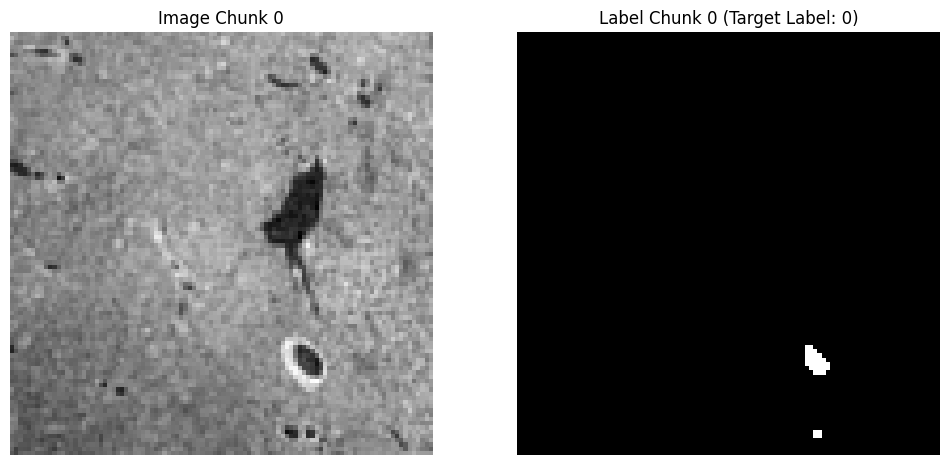

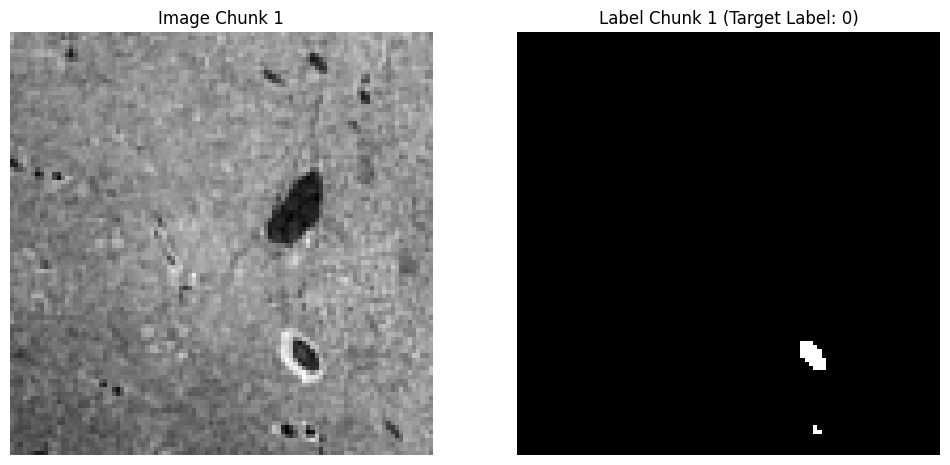

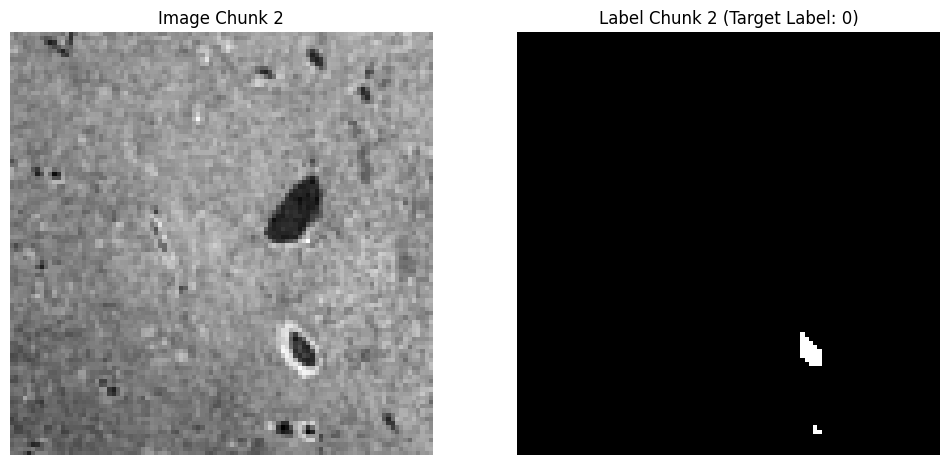

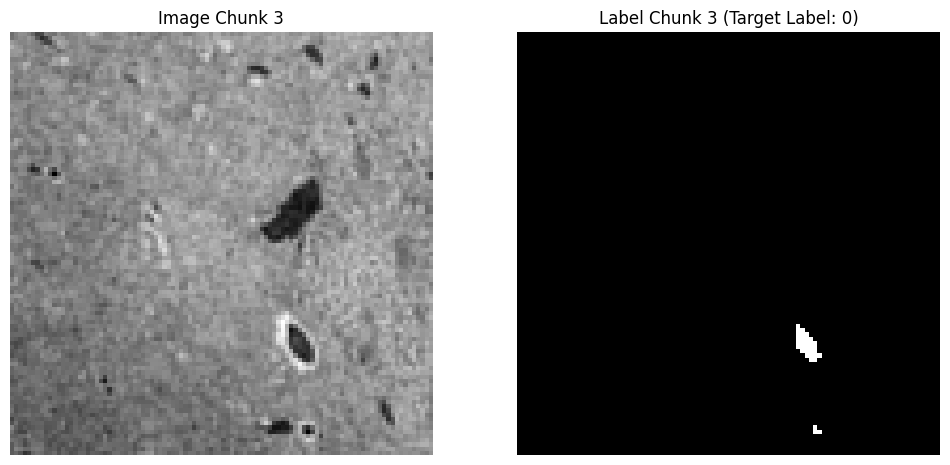

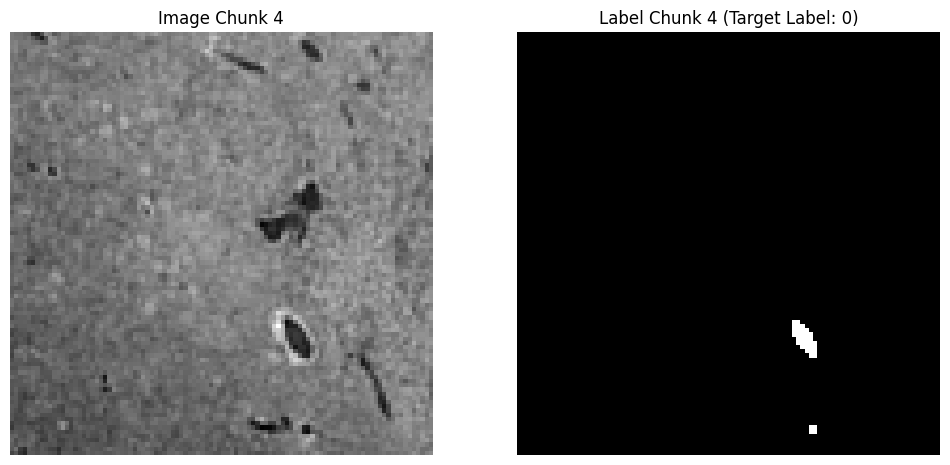

In [22]:
##### example code to visualise a chunk that has been saved as a tensor
def from_tensor_chunk_visualise(file_path):
    import torch
    from torchvision.transforms import ToPILImage
    import matplotlib.pyplot as plt

    # Path to the .pt file
    file_path = 'chunks/300_500_2_0.pt'

    # Load the data
    data = torch.load(file_path)

    # Extract the image and label tensors
    image_tensors = data['images']
    label_tensors = data['labels']
    target_label = data['target_label']

    # Convert tensors to PIL Images
    to_pil_image = ToPILImage()
    images = [to_pil_image(img) for img in image_tensors]
    labels = [to_pil_image(lbl) for lbl in label_tensors]

    # Display the images and labels
    for i in range(len(images)):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image Chunk {i}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(labels[i], cmap='gray')
        plt.title(f'Label Chunk {i} (Target Label: {target_label.item()})')
        plt.axis('off')

        plt.show()

    

In [30]:
######
train_folder = 'chunks/train'
test_folder = 'chunks/test'

train_dataset = CustomDataset(train_folder)
test_dataset = CustomDataset(test_folder)
batch_size = 64  # Adjust this based on your specific data size and memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


DataLoader Instantiation
You'll need to determine an appropriate batch_size to ensure each DataLoader is around 1GB. The calculation depends on the size of each sample and the memory it consumes. Here's a basic framework to create the DataLoader objects:

python
Copy code
# Placeholder for batch size - replace with your calculated value
batch_size = 64  # Adjust this based on your specific data size and memory constraints

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
Batch Size Calculation
To estimate an appropriate batch_size, you need to consider the size of each tensor (image stack) in your dataset. Assuming each image is a 5-channel grayscale image and each channel is of size 
�
×
�
H×W (height x width), the size in bytes for each image stack is approximately:

Image Stack Size in Bytes
=
�
×
�
×
5
×
bytes per pixel
Image Stack Size in Bytes=H×W×5×bytes per pixel

For a float32 tensor, bytes per pixel is 4. Then, estimate batch_size as:

Batch Size
=
Target DataLoader Size in Bytes
Image Stack Size in Bytes
Batch Size= 
Image Stack Size in Bytes
Target DataLoader Size in Bytes
​


<class 'dict'>


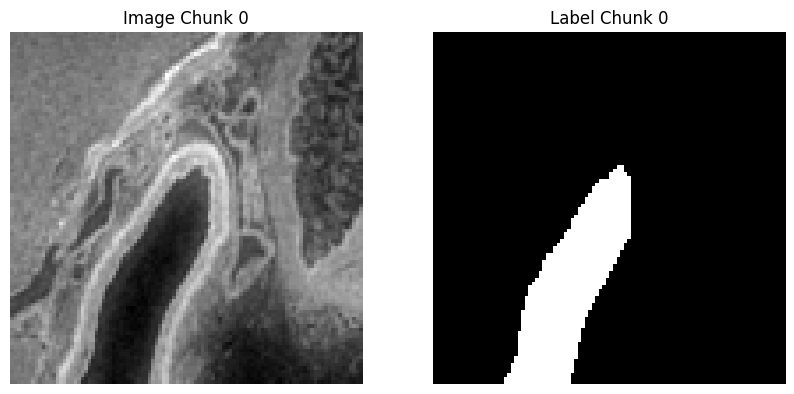

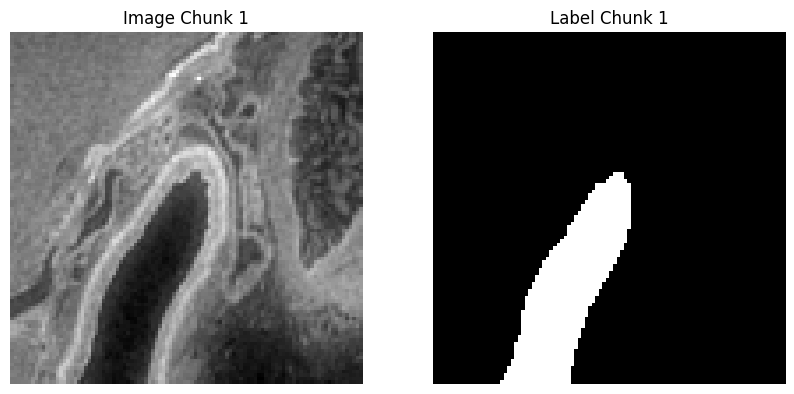

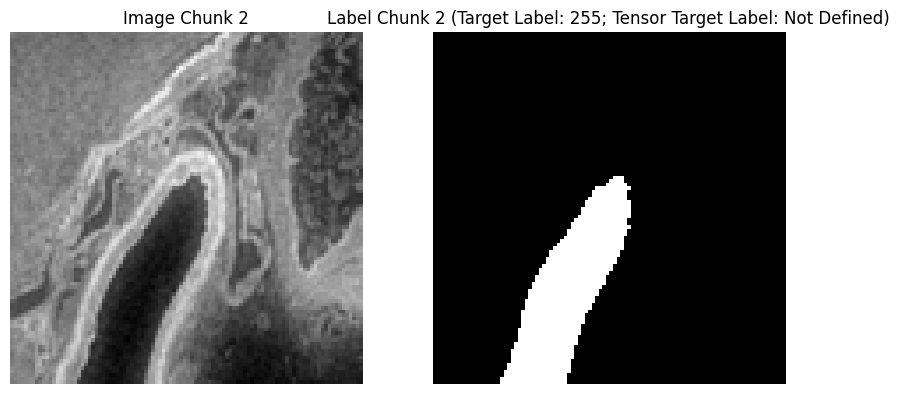

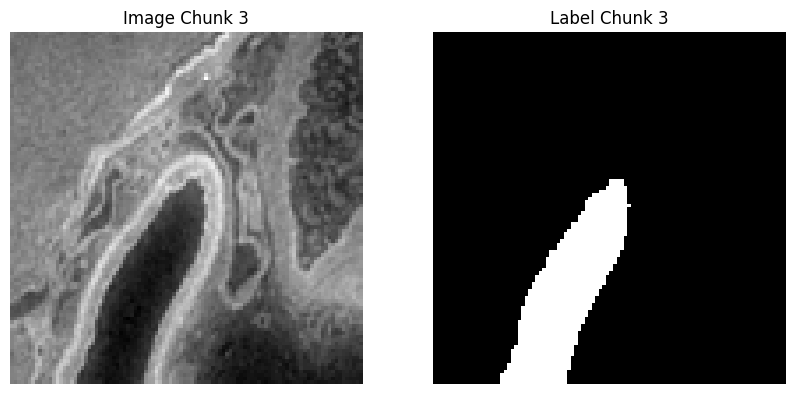

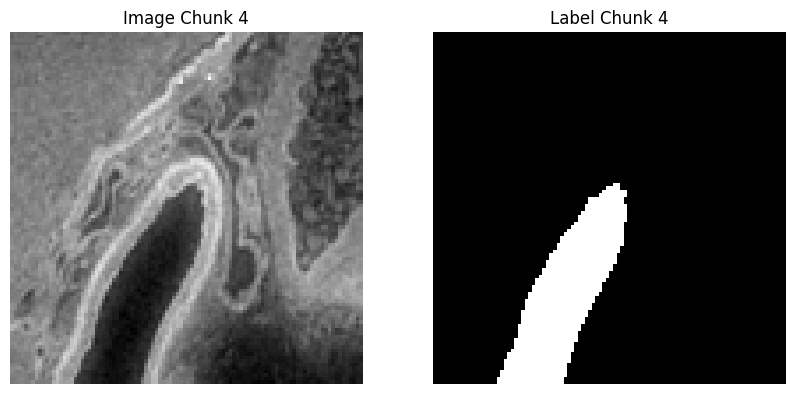

In [54]:


# Create an instance of ImageChunker
chunker = ImageChunker()

# Specify the coordinates for the target pixel
target_x, target_y = 390, 630  # Example coordinates

# Extract a chunk
chunk = chunker.extract_chunk_and_label(image_stack, label_stack, target_x, target_y)

# Visualize the chunk
chunker.visualize_chunks(chunk)




In [55]:
type(chunk)

__main__.Chunk

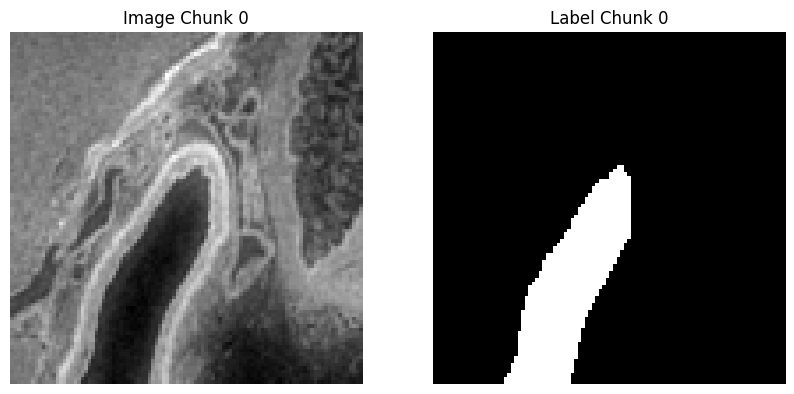

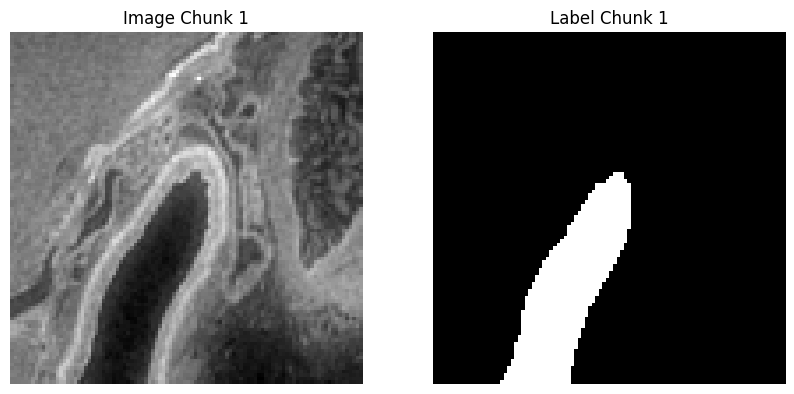

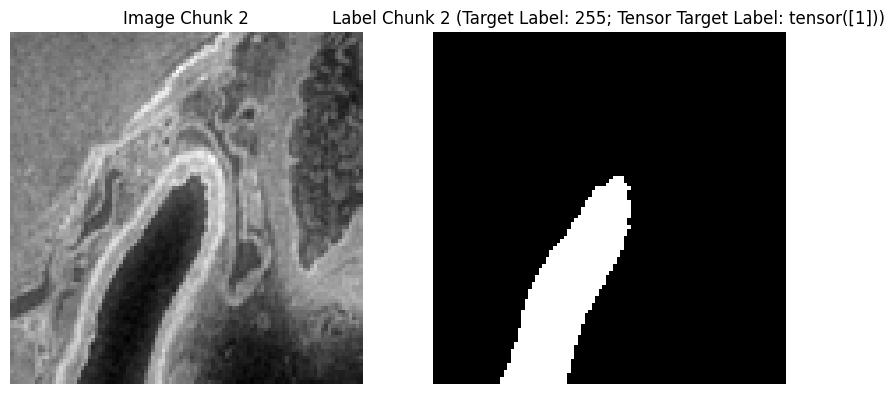

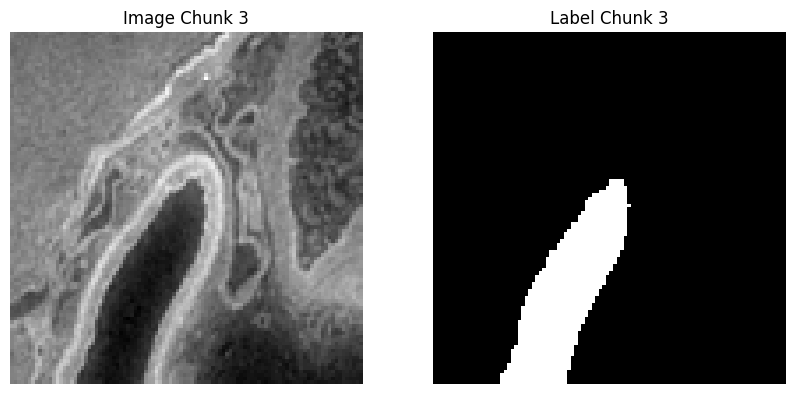

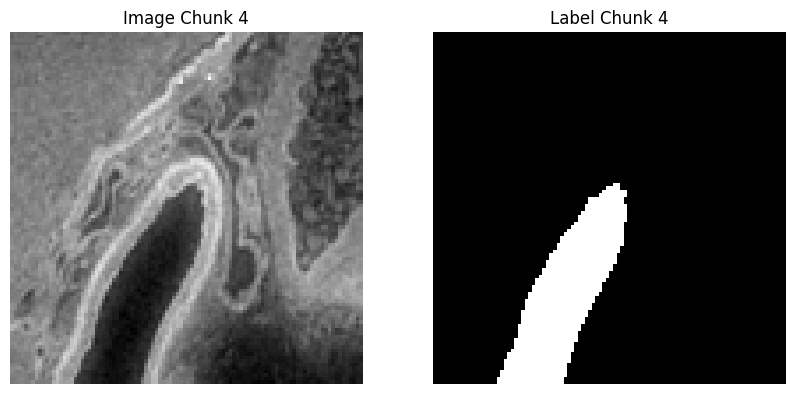

In [56]:
# Assuming you have a 'chunk' object

# Convert to tensor (with normalization)
chunk.to_tensor()

# Convert back to chunk (with inverse normalization)
chunk.to_chunk()

# Visualize the chunk
chunker = ImageChunker()
chunker.visualize_chunks(chunk)


In [58]:
slice_stacker = SliceStacker(slice_collection.slices, channel_count=5)

In [59]:
centered_stack_images, centered_stack_labels = slice_stacker.get_stacked_images_and_labels(1)

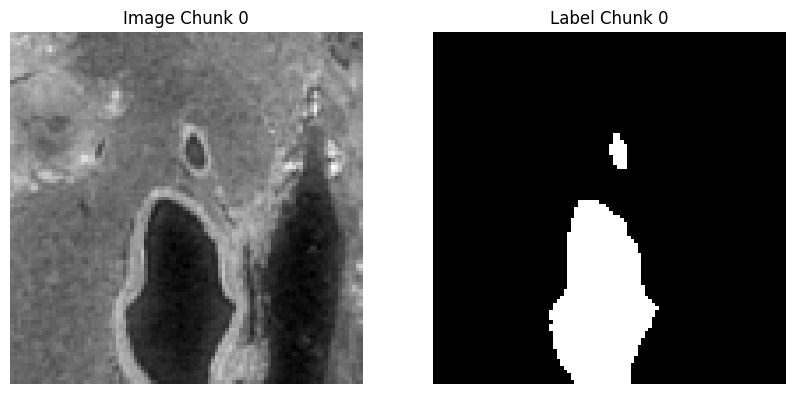

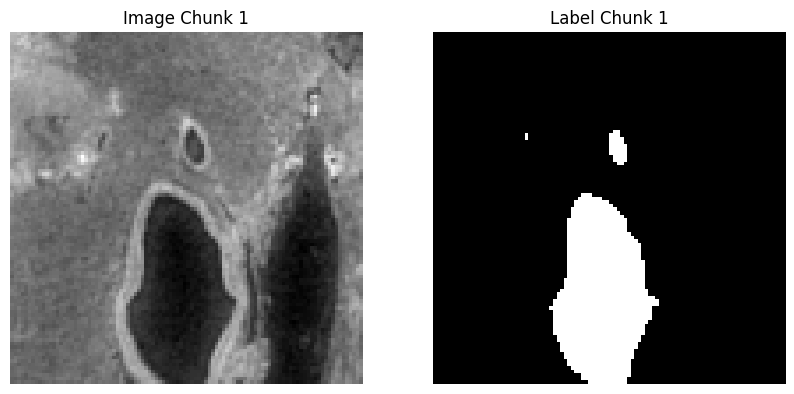

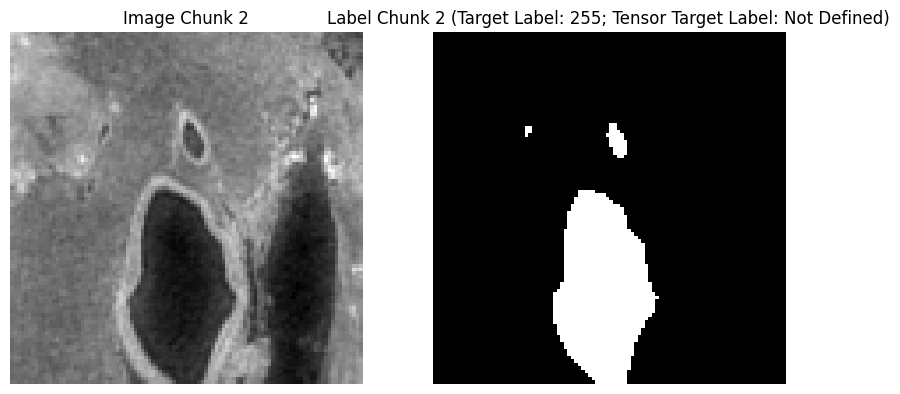

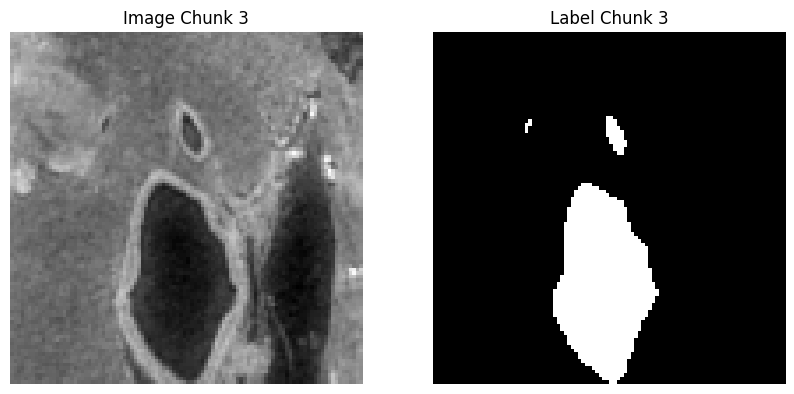

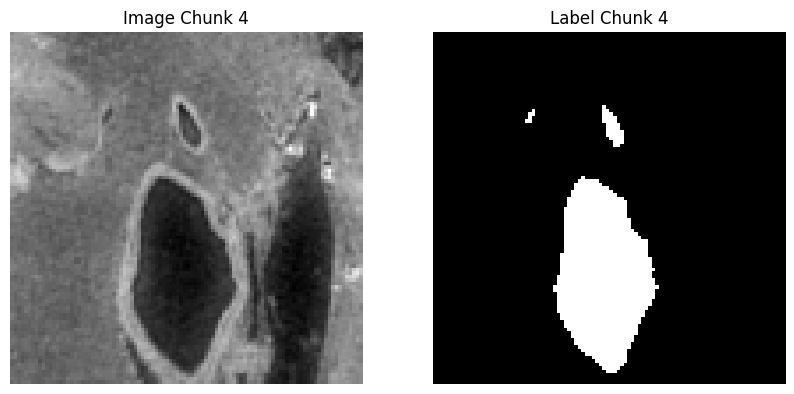

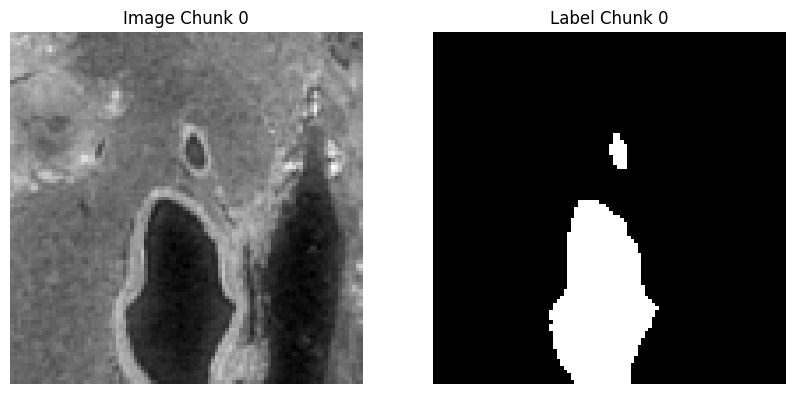

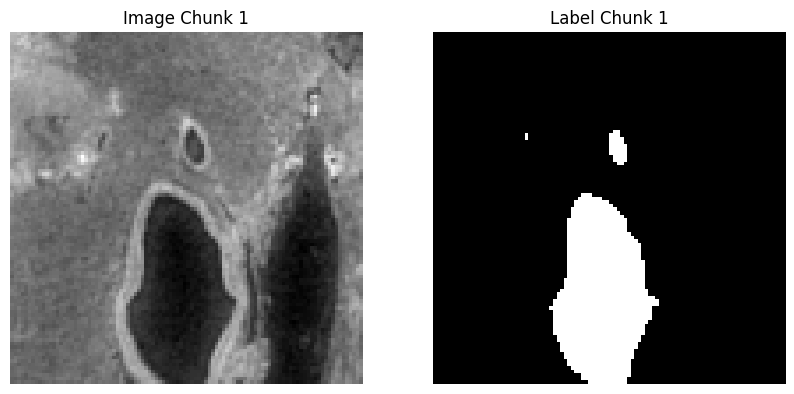

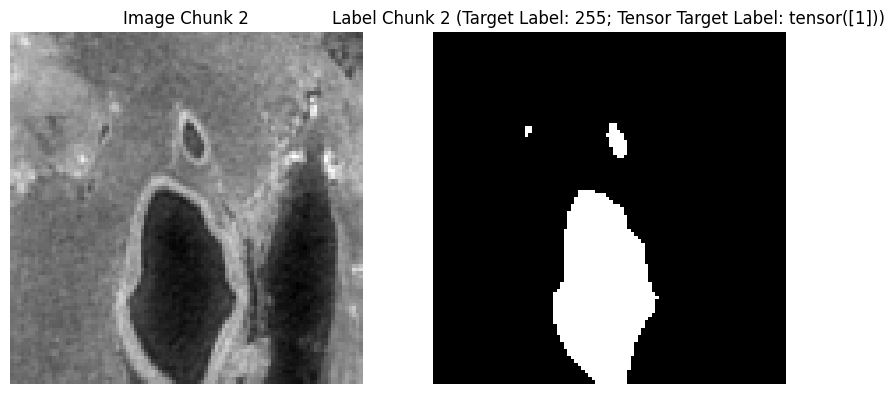

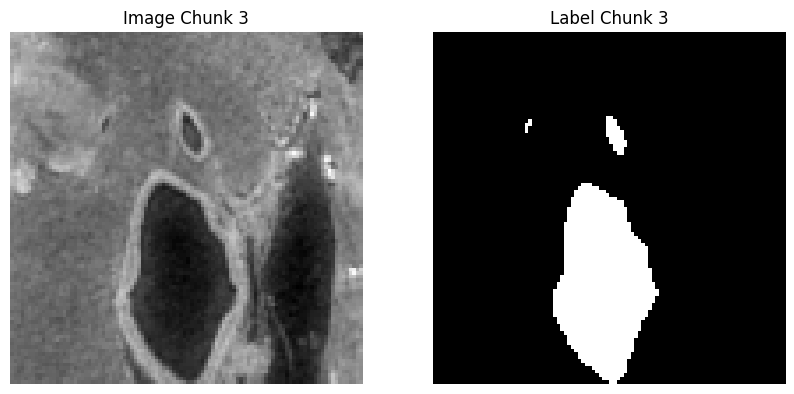

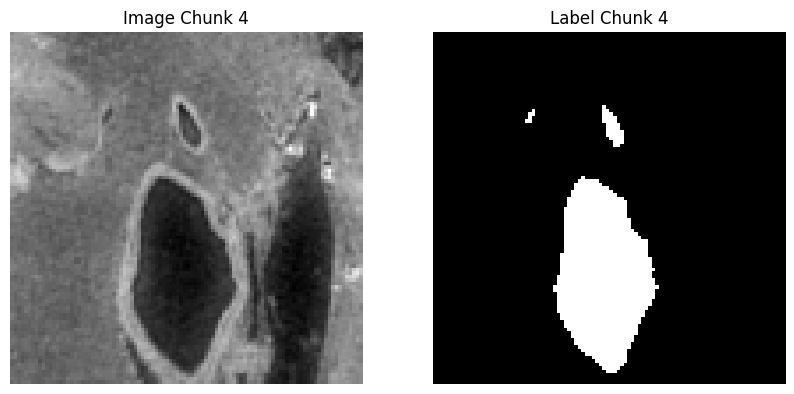

In [88]:
# Initialize the SliceStacker with a collection of Slice objects
slice_stacker = SliceStacker(slice_collection.slices, channel_count=5)

# For a given target index, get the stack of images and labels
target_index = 1500  # Example target index
stacked_images, stacked_labels = slice_stacker.get_stacked_images_and_labels(target_index)

# Initialize your Chunker

# Create an instance of ImageChunker
chunker = ImageChunker()

# Specify the coordinates for the target pixel
target_x, target_y = 480, 550  # Example coordinates

# Extract a chunk
chunk = chunker.extract_chunk_and_label(stacked_images, stacked_labels, target_x, target_y)

# Visualize the chunk
chunker.visualize_chunks(chunk)
chunk.to_tensor()
chunk.to_chunk()
chunker.visualize_chunks(chunk)
